In [1]:
# Install necessary libraries
!pip install opencv-python tensorflow scikit-learn matplotlib


In [ ]:
# Import required libraries
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator



In [8]:
glass_dir = r"RealHumanGlass/Glass"       # folder with Glass images
notglass_dir = r"RealHumanGlass/NotGlass" # folder with NotGlass images

IMG_SIZE = 100  # image resize size


In [9]:
# Load Haar Cascade for face detection
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")

data = []
labels = []

def process_images(folder, label):
    for img_name in os.listdir(folder):
        img_path = os.path.join(folder, img_name)
        img = cv2.imread(img_path)
        if img is None:
            continue
        
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=4)

        if len(faces) > 0:
            # Crop first detected face
            (x, y, w, h) = faces[0]
            face_img = img[y:y+h, x:x+w]
        else:
            face_img = img  # if no face detected, use full image

        face_img = cv2.resize(face_img, (IMG_SIZE, IMG_SIZE))
        face_img = cv2.cvtColor(face_img, cv2.COLOR_BGR2RGB)
        data.append(face_img)
        labels.append(label)

# Load Glass (label 0) and NotGlass (label 1)
process_images(glass_dir, 0)
process_images(notglass_dir, 1)

# Convert to numpy arrays
data = np.array(data) / 255.0
labels = np.array(labels)

print(f" Data loaded: {data.shape[0]} images")


 Data loaded: 17000 images


In [10]:
# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    data, labels, test_size=0.2, random_state=42, stratify=labels
)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)


Train shape: (13600, 100, 100, 3) Test shape: (3400, 100, 100, 3)


In [11]:
# Define data augmentation to improve model generalization
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)
datagen.fit(X_train)


In [12]:
# Build CNN model
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),                     # dropout to prevent overfitting
    Dense(1, activation='sigmoid')    # output layer for binary classification
])

C:\Users\Aziz\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [13]:
# Compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 98, 98, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 49, 49, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 47, 47, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 23, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 33856)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     4,333,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,353,217 (16.61 MB)

 Trainable params: 4,353,217 (16.61 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
# Train the model with augmented data
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    validation_data=(X_test, y_test),
    epochs=10
)


Epoch 1/10


C:\Users\Aziz\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


425/425 ━━━━━━━━━━━━━━━━━━━━ 109s 248ms/step - accuracy: 0.7342 - loss: 0.5751 - val_accuracy: 0.8968 - val_loss: 0.2511
Epoch 2/10
425/425 ━━━━━━━━━━━━━━━━━━━━ 97s 226ms/step - accuracy: 0.8377 - loss: 0.3765 - val_accuracy: 0.9197 - val_loss: 0.2019
Epoch 3/10
425/425 ━━━━━━━━━━━━━━━━━━━━ 87s 203ms/step - accuracy: 0.8741 - loss: 0.3139 - val_accuracy: 0.9338 - val_loss: 0.1641
Epoch 4/10
425/425 ━━━━━━━━━━━━━━━━━━━━ 88s 207ms/step - accuracy: 0.8914 - loss: 0.2638 - val_accuracy: 0.9476 - val_loss: 0.1315
Epoch 5/10
425/425 ━━━━━━━━━━━━━━━━━━━━ 88s 205ms/step - accuracy: 0.9168 - loss: 0.2176 - val_accuracy: 0.9500 - val_loss: 0.1330
Epoch 6/10
425/425 ━━━━━━━━━━━━━━━━━━━━ 91s 212ms/step - accuracy: 0.9142 - loss: 0.2181 - val_accuracy: 0.9553 - val_loss: 0.1099
Epoch 7/10
425/425 ━━━━━━━━━━━━━━━━━━━━ 89s 209ms/step - accuracy: 0.9172 - loss: 0.2039 - val_accuracy: 0.9535 - val_loss: 0.1117
Epoch 8/10
425/425 ━━━━━━━━━━━━━━━━━━━━ 87s 204ms/step - accuracy: 0.9256 - loss: 0.1915 - va

In [15]:
# Evaluate the model on test set
loss, acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {acc*100:.2f}%")


107/107 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - accuracy: 0.9578 - loss: 0.1092
Test Accuracy: 95.71%


In [16]:
# Generate predictions for classification report and confusion matrix
y_pred = (model.predict(X_test) > 0.5).astype("int32")

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=["Glass", "NotGlass"]))

107/107 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step

Classification Report:
              precision    recall  f1-score   support

       Glass       0.96      0.95      0.96      1700
    NotGlass       0.95      0.97      0.96      1700

    accuracy                           0.96      3400
   macro avg       0.96      0.96      0.96      3400
weighted avg       0.96      0.96      0.96      3400



In [17]:
# Print confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Confusion Matrix:
[[1613   87]
 [  59 1641]]


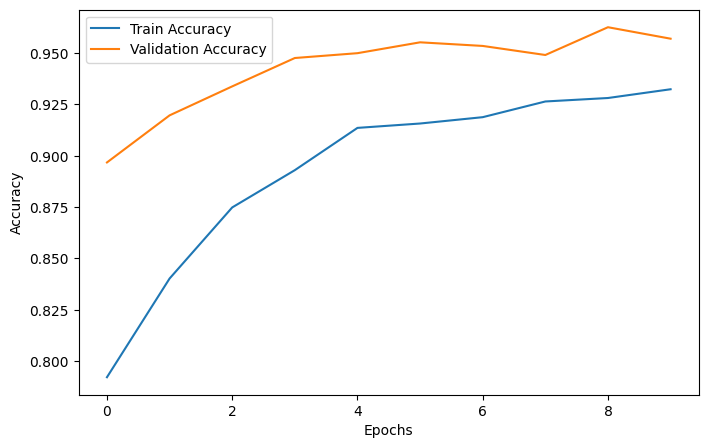

In [18]:
# Plot training and validation accuracy over epochs
plt.figure(figsize=(8,5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


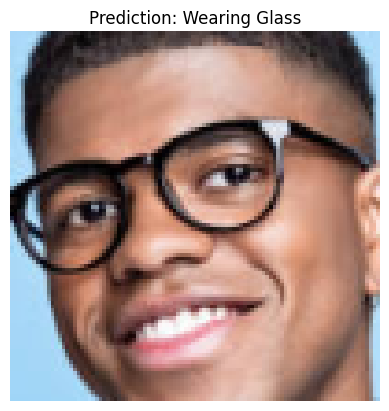

In [21]:
# Test the model on a single unseen image
test_img_path = r"image1.png"  
img = cv2.imread(test_img_path)

# Detect face in the image
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=4)

if len(faces) > 0:
    (x, y, w, h) = faces[0]
    img = img[y:y+h, x:x+w]

# Preprocess the image (resize + normalize)
img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(img)
plt.axis('off')

# Predict using the model
pred = model.predict(np.expand_dims(img/255.0, axis=0))[0][0]
plt.title("Prediction: Wearing Glass" if pred < 0.5 else "Prediction: NotGlass")
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


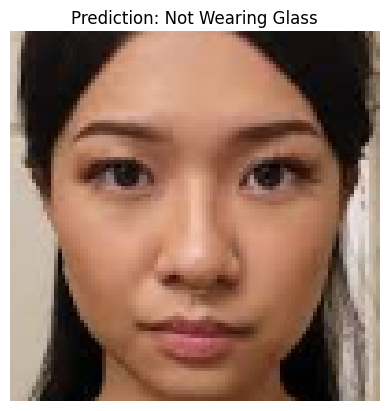

In [22]:
# Another unseen image test
test_img_path = r"image.png"  
img = cv2.imread(test_img_path)

# Detect face
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=4)

if len(faces) > 0:
    (x, y, w, h) = faces[0]
    img = img[y:y+h, x:x+w]

# Preprocess
img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(img)
plt.axis('off')

# Prediction
pred = model.predict(np.expand_dims(img/255.0, axis=0))[0][0]
plt.title("Prediction: Wearing Glass" if pred < 0.5 else "Prediction: Not Wearing Glass")
plt.show()
